In [1]:
from utils import DateSet, numpy2gpu,load_split_data
from utils import gen_tests_of_deblur,x_post_sample_modify,prior_mean_cov
from utils import sample_cumulated_sum
from function import get_x_ml,x_post_sample_modify
from cvae_model.visualize import printdict # 更改

%matplotlib inline

In [2]:
%run cvae_model/problem_setting.py

sigma_range: [0.01, 0.03, 0.05]
noise_num: 3
M_samples_per_para: 20000
x_dim: 50
data_dim: 50
sigma_prior: 0.1
    H: (50, 50)
data_file_prefix: data\signal_denoise_mu3_0.01_0.03_M20000
---------------------------------------------------------------------------
number of samples: 3*  20000  (noise_num*M_samples_per_para)
---------------------------------------------------------------------------


In [3]:
device = 'cpu'

In [4]:
class VAE(nn.Module):

    def __init__(self, feature,classes,encoder_layer_sizes, latent_size, decoder_layer_sizes,
                 conditional=True, num_labels=0):
        super().__init__()

        if conditional:
            assert num_labels > 0

        assert type(encoder_layer_sizes) == list
        # assert type(layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list

        self.latent_size = latent_size
        self.net = NN(feature,classes)
        self.encoder = Encoder(
            encoder_layer_sizes, latent_size, conditional, num_labels)
        self.decoder = Decoder(
            decoder_layer_sizes, latent_size, conditional, num_labels)

    def forward(self, x, unkown, data):
        data_size = data.shape[1]
        data = self.net(data)
        class_data = torch.max(data, 1).indices.float().reshape(-1, 1)
        class_data = class_data @ torch.ones(1,data_size).to(device)
        c = torch.cat([unkown, class_data], dim=1)
        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)

        return recon_x, z, data, class_data[0]

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, unkown, data):
        data_size = data.shape[1]
        data = self.net(data)
        class_data = torch.max(data, 1).indices.float().reshape(-1, 1)
        class_data = class_data @ torch.ones(1,data_size).to(device)
        c = torch.cat([unkown, class_data], dim=1)
        recon_x = self.decoder(z, c)
        return recon_x,data,class_data


class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.conditional = conditional
        if self.conditional:
            layer_sizes[0] += num_labels

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i + 2 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU())

        self.linear_means = nn.Sequential(nn.Linear(layer_sizes[-1], latent_size),nn.BatchNorm1d(latent_size))
        # self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):

        if self.conditional:
            x = torch.cat((x, c), dim=-1)

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()
        self.conditional = conditional
        if self.conditional:
            input_size = latent_size + num_labels
        else:
            input_size = latent_size

        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i + 1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU())
                # self.MLP.add_module(name="B{:d}".format(i), module=nn.BatchNorm1d(out_size))
            # else:
            #     self.MLP.add_module(name="Output", module=nn.Softplus())#[batchsize,layer_sizes[-1]]

    # 最后一层不可以是1了...只能是指定的类别
    def forward(self, z, c):
        if self.conditional:
            z = torch.cat((z, c), dim=1)
        x = self.MLP(z)
        out = x
        return out


# class NN(nn.Module):
#     def __init__(self, layer_size):
#         super(NN, self).__init__()  # 调用父类的初始化函数
#         assert type(layer_size) == list
#         self.classMLP = nn.Sequential()
#         for i, (in_size, out_size) in enumerate(zip(layer_size[:-1], layer_size[1:])):
#             self.classMLP.add_module(name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
#             if i + 2 < len(layer_size):
#                 self.classMLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU())

#     def forward(self, data):
#         data = self.classMLP(data)
#         data = torch.nn.functional.softmax(data,dim=1)
#         return data

class Residual_block(nn.Module):
    def __init__(self,in_features,out_features,hidden_features = 100):
        super().__init__()

        self.dense0 = nn.Linear(in_features,hidden_features)
        self.dropout0 = nn.Dropout(p=0.2)

        self.dense1 = nn.Linear(hidden_features,out_features)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dense_skip = nn.Linear(in_features,out_features)

    def forward(self,input):
        l1 = nn.LeakyReLU()(self.dropout0(self.dense0(input)))
        l2 = nn.LeakyReLU()(self.dropout1(self.dense1(l1)))
        skip = nn.LeakyReLU()(self.dense_skip(input))
        output = skip+l2
        return output
    
class NN(nn.Module):
    def __init__(self,feature,classs):
        super().__init__()
        
        self.MLP = nn.Sequential(Residual_block(feature,feature),Residual_block(feature,feature),
                        Residual_block(feature,feature),
                        nn.Linear(feature,classs))
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
        
    def forward(self,input):
        output = self.MLP(input)
        return output

In [15]:
class VAE(nn.Module):

    def __init__(self, layer_sizes, encoder_layer_sizes, latent_size, decoder_layer_sizes,
                 conditional=True, num_labels=0):
        super().__init__()

        if conditional:
            assert num_labels > 0

        assert type(encoder_layer_sizes) == list
        assert type(layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list

        self.latent_size = latent_size
        self.net = NN(layer_sizes)
        self.encoder = Encoder(
            encoder_layer_sizes, latent_size, conditional, num_labels)
        self.decoder = Decoder(
            decoder_layer_sizes, latent_size, conditional, num_labels)

    def forward(self, x, unkown, data):
        data_size = data.shape[1]
        data = self.net(data)
        class_data = torch.max(data, 1).indices.float().reshape(-1, 1)
        class_data = class_data @ torch.ones(1,data_size).to(device)
        c = torch.cat([unkown, class_data], dim=1)
        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)

        return recon_x, z, data, class_data[0]

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, unkown, data):
        data_size = data.shape[1]
        data = self.net(data)
        class_data = torch.max(data, 1).indices.float().reshape(-1, 1)
        class_data = class_data @ torch.ones(1,data_size).to(device)
        c = torch.cat([unkown, class_data], dim=1)
        recon_x = self.decoder(z, c)
        return recon_x,data,class_data


class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.conditional = conditional
        if self.conditional:
            layer_sizes[0] += num_labels

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i + 2 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU())

        # self.linear_means = nn.Sequential(nn.Linear(layer_sizes[-1], latent_size),nn.BatchNorm1d(latent_size))
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):

        if self.conditional:
            x = torch.cat((x, c), dim=-1)

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()
        self.conditional = conditional
        if self.conditional:
            input_size = latent_size + num_labels
        else:
            input_size = latent_size

        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i + 1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU())
                # self.MLP.add_module(name="B{:d}".format(i), module=nn.BatchNorm1d(out_size))
            # else:
            #     self.MLP.add_module(name="Output", module=nn.Softplus())#[batchsize,layer_sizes[-1]]

    # 最后一层不可以是1了...只能是指定的类别
    def forward(self, z, c):
        if self.conditional:
            z = torch.cat((z, c), dim=1)
        x = self.MLP(z)
        out = x
        return out


class NN(nn.Module):
    def __init__(self, layer_size):
        super(NN, self).__init__()  # 调用父类的初始化函数
        assert type(layer_size) == list
        self.classMLP = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_size[:-1], layer_size[1:])):
            self.classMLP.add_module(name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i + 2 < len(layer_size):
                self.classMLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU())

    def forward(self, data):
        data = self.classMLP(data)
        data = torch.nn.functional.softmax(data,dim=1)
        return data


# load model and simulate test data 

In [5]:
model_file_name = '0524_bn_cvae_class3_lr1e-05_accuracy0.53125' #??

args = np.load(os.path.join('saved_model',model_file_name)+"_args.npy",allow_pickle=True).item()
hypers = np.load(os.path.join('saved_model',model_file_name)+"_hypers.npy",allow_pickle=True).item() ##############??

print(model_file_name)
printdict(args),printdict(hypers)

cvae = torch.load(os.path.join('saved_model',model_file_name)+".pth").to('cpu') #??

0524_bn_cvae_class3_lr1e-05_accuracy0.53125
epochs: 40
batch_size: 64
layer_sizes: [50, 100, 200, 400, 200, 100, 50, 20, 3]
encoder_layer_sizes: [101, 200, 100, 50, 30, 10]
decoder_layer_sizes: [200, 100, 50, 30, 12, 5, 1]
latent_size: 2
print_every: 5000
fig_root: figs
conditional: True
sigma_range: [0.01, 0.03, 0.05]
noise_num: 3
M_samples_per_para: 20000
x_dim: 50
data_dim: 50
sigma_prior: 0.1
    H: (50, 50)
data_file_prefix: data/signal_denoise_mu3_0.01_0.03_M20000


# test

In [23]:
x_dim = hypers['x_dim']
n = 1 # 一共有10个数据
C = np.identity(x_dim) * (hypers['sigma_prior']**2)
x = np.random.multivariate_normal([0] * x_dim, C,n) # [M,x_dim]

In [ ]:
theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x).float(),torch.tensor(y_j.T).float().reshape(1,-1))

In [22]:
x_0.T.shape

(1, 50)

In [24]:
x.shape

(1, 50)

# 产生真实数据

In [6]:
x = pd.read_csv(r'D:\LiulanqiDownload\jupyter code\2021论文\signal_denoise\x.csv',header=None)

In [7]:
x = np.array(x)

In [8]:
n = 20

In [79]:
truth = pd.DataFrame(np.mean(x,0))
truth.to_csv('gt.csv')

# 没有标准化的版本

1.从x的先验分布中抽样产生了20个无噪音干扰的信号值X；2.针对每一个信号值，分别使用两种方法进行对比。我们的方法与AGEM方法抽样的数目为1000次。

In [7]:
x_dim = hypers['x_dim']
n = 1 # 一共有10个数据
C = np.identity(x_dim) * (hypers['sigma_prior']**2)
x = np.random.multivariate_normal([0] * x_dim, C,n) 

In [86]:
theta_0_gpu,classes

(tensor([[0.0226]], grad_fn=<AddmmBackward0>),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]))

In [25]:
# [M,x_dim]

for i in range(10):
    # x = np.random.multivariate_normal([0] * x_dim, C,n)
    b = np.random.randn(1,50) * 0.05
    z = torch.randn([1, 5])
    y = x + b
    x_0 =  get_x_ml(y,hypers)
    # x_0 = np.random.multivariate_normal([0] * x_dim, C,n) .T
    theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x_0.T).float(),torch.tensor(y.T).float().reshape(1,-1))
    
    # if theta_0_gpu <=0.02:
    print(theta_0_gpu,classes)
 
    # if classes[0][0]==2:
    #     print(theta_0_gpu)
    #     break

[-0.20154257 -0.05825211  0.04590706  0.11341348  0.10579308 -0.12378718
 -0.07778999 -0.03277799 -0.02742185  0.14856825  0.0586014  -0.07712998
 -0.01236319 -0.05780515  0.203189    0.040509    0.18596863  0.04839848
  0.01667894  0.00705331  0.18352318  0.15004759 -0.04799447 -0.15526241
 -0.18560074  0.05501587  0.08466795 -0.0141447   0.10880269  0.08078488
  0.06253116 -0.09945541 -0.24109735 -0.16787838  0.15563407 -0.0955862
  0.08019653  0.03398956 -0.15758084  0.07672417 -0.04449069 -0.14740187
  0.13174537 -0.13474907  0.01276222  0.05234089  0.06342796  0.02939549
 -0.07206927 -0.16781844]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x105 and 102x200)

In [21]:
y_1 = y

In [17]:
y_2 = y

In [33]:
np.savez('y.npz', y0=y_0, y1=y_1,y2=y_2)

In [74]:
y = np.load('data/y.npz')

In [75]:
y =y['y2']

In [86]:
for i in range(100):
    for sigma_true in [0.05]: #
        hypers['sigma_noise'] = sigma_true
        sigma_noise = hypers['sigma_noise']
        # # np.random.seed(0)
        Hx = x
        b = np.random.randn(n,50) * sigma_noise
        y = Hx + b

        THETA_mean = np.zeros([n,1])
        THETA_var = np.zeros([n,1])
        RMSE = np.zeros([n,1])
    #     X_var = np.zeros([n,1])

    #     init=np.zeros([n,1])

        for j in tqdm(range(n)):    
            # def Gibbs_sample(N,use_sample_size,x_truth,y,hypers,show_step=200,theta_truth=None):
            N = 1000
            use_sample_size = 500
            x_truth = x[j].reshape(-1,1) # 50,n
            theta_truth = np.zeros(1)#??
            m = hypers['x_dim']
            y_j = y[j]

            x_0 =  get_x_ml(y_j,hypers)
            x_init_value = x_0
    #         init[j] = x_init_value

            x_sum,x_square_sum = np.zeros_like(x_truth),np.zeros_like(x_truth)
            theta_sum,theta_square_sum = np.zeros_like(theta_truth),np.zeros_like(theta_truth)  

            z = torch.randn([1, args['latent_size']])
            for i in range(N):
                # sample theta
                c = torch.cat((torch.tensor(x_0).float(),torch.tensor(y_j.reshape(-1,1)).float()),dim=0).T.to(device)
                theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x_0.T).float(),torch.tensor(y_j.T).float().reshape(1,-1)) #更改
                theta_0 = theta_0_gpu.detach().cpu().numpy()[0]
              # 因为之前在训练网络的时候，训练数据的时候我们先标准化数据了。这个时候需要标准化回来。乘以的也是原本训练时候的均值与方差
                # sample x
                sigma = theta_0
                t.append(sigma)

                x_0,_,_ = x_post_sample_modify(m,hypers['sigma_prior'],sigma,y_j.reshape(-1,1))
    #             X.append(np.sqrt(((x_0 - x_truth)**2).sum()/50))

                if i>(N-use_sample_size-1):
                    theta_sum,theta_square_sum = sample_cumulated_sum(theta_sum,theta_square_sum,theta_0)
                    x_sum,x_square_sum = sample_cumulated_sum(x_sum,x_square_sum,x_0)   

            x_mean = x_sum/use_sample_size
            x_var = x_square_sum/use_sample_size-x_mean**2

            theta_mean = theta_sum/use_sample_size
            theta_var = theta_square_sum/use_sample_size-theta_mean**2
            rmse = np.sqrt(((x_mean - x_truth)**2).sum()/50)

            THETA_mean[j] = theta_mean
            THETA_var[j] = theta_var
            RMSE[j] = rmse
    #         X_var[j] = x_var
    #         X_mean.append(x_mean)
    #         RMSE_total.append(rmse)
        
        noise_mean = THETA_mean.mean()
        noise_std = np.sqrt(THETA_var).mean()
    #     signal_var = X_var.mean()
        rmse_mean = RMSE.mean()
        if noise_mean>=0.04:
            print(classes)
            print('[CVAE_within_Gibbd] noise_gt: %.2f | rmse %.4f, noise_est: %.4f(%.6f)' % (sigma_true, rmse_mean, noise_mean,noise_std))
            np.savez('y_0.05.npz', y)
            break
        break
    break


        

    # 每一个参数测试20次，每次固定参数以后，在第2次的时候，得到的x_mean将和对应的x_truth求RMSE。

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
[CVAE_within_Gibbd] noise_gt: 0.05 | rmse 0.0520, noise_est: 0.0410(0.001416)


  0%|                                                                                            | 0/1 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [60]:
# RMSE_total = []
# X_mean = []
x_dim = hypers['x_dim']
n = 1 # 一共有10个数据
# np.random.seed(1)
C = np.identity(x_dim) * (hypers['sigma_prior']**2)
x = np.random.multivariate_normal([0] * x_dim, C,n) # [M,x_dim]

In [72]:
# x_truth = x
np.save('data/x_truth',x_truth)

In [105]:
for test_num in tqdm(range(30)):
    t = []
    for sigma_true in [0.01]: #
        hypers['sigma_noise'] = sigma_true
        sigma_noise = hypers['sigma_noise']
        Hx = x
        b = np.random.randn(n,50) * sigma_noise
        y = Hx + b
        


        THETA_mean = np.zeros([n,1])
        THETA_var = np.zeros([n,1])
        RMSE = np.zeros([n,1])

        # np.random.seed(7)
        # torch.manual_seed(7)
        for j in range(n):    
            # def Gibbs_sample(N,use_sample_size,x_truth,y,hypers,show_step=200,theta_truth=None):
            N = 10000
            use_sample_size = 5000
            x_truth = x[j].reshape(-1,1) # 50,n
            theta_truth = np.zeros(1)#??
            m = hypers['x_dim']
            y_j = y[j]

            x_0 =  get_x_ml(y_j,hypers)
            x_init_value = x_0
    #         init[j] = x_init_value

            x_sum,x_square_sum = np.zeros_like(x_truth),np.zeros_like(x_truth)
            theta_sum,theta_square_sum = np.zeros_like(theta_truth),np.zeros_like(theta_truth)  

            z = torch.randn([1, args['latent_size']])
            for i in range(N):
                # sample theta
                c = torch.cat((torch.tensor(x_0).float(),torch.tensor(y_j.reshape(-1,1)).float()),dim=0).T.to(device)
                theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x_0.T).float(),torch.tensor(y_j.T).float().reshape(1,-1)) #更改
                theta_0 = theta_0_gpu.detach().cpu().numpy()[0]
              # 因为之前在训练网络的时候，训练数据的时候我们先标准化数据了。这个时候需要标准化回来。乘以的也是原本训练时候的均值与方差
                # sample x
                sigma = theta_0
                t.append(sigma)

                x_0,_,_ = x_post_sample_modify(m,hypers['sigma_prior'],sigma,y_j.reshape(-1,1))
    #             X.append(np.sqrt(((x_0 - x_truth)**2).sum()/50))

                if i>(N-use_sample_size-1):
                    theta_sum,theta_square_sum = sample_cumulated_sum(theta_sum,theta_square_sum,theta_0)
                    x_sum,x_square_sum = sample_cumulated_sum(x_sum,x_square_sum,x_0)   

            x_mean = x_sum/use_sample_size
            x_var = x_square_sum/use_sample_size-x_mean**2

            theta_mean = theta_sum/use_sample_size
            theta_var = theta_square_sum/use_sample_size-theta_mean**2
            rmse = np.sqrt(((x_mean - x_truth)**2).sum()/50)

            THETA_mean[j] = theta_mean
            THETA_var[j] = theta_var
            RMSE[j] = rmse

        print(classes[0][0])
        noise_mean = THETA_mean.mean()
        noise_std = np.sqrt(THETA_var).mean()
        rmse_mean = RMSE.mean()

        print('[CVAE_within_Gibbd] noise_gt: %.2f | rmse %.4f, noise_est: %.4f(%.6f)' % (
        sigma_true, rmse_mean, noise_mean,noise_std
    ))
        if noise_mean<=0.02:
            np.save(f'data/y{test_num}_{sigma_noise}.npy',y)



    # 每一个参数测试20次，每次固定参数以后，在第2次的时候，得到的x_mean将和对应的x_truth求RMSE。

  3%|██▊                                                                                | 1/30 [00:06<02:55,  6.03s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0098, noise_est: 0.0232(0.000549)


  7%|█████▌                                                                             | 2/30 [00:12<02:48,  6.02s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0107, noise_est: 0.0231(0.000670)


 10%|████████▎                                                                          | 3/30 [00:19<03:05,  6.87s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0121, noise_est: 0.0262(0.000756)


 13%|███████████                                                                        | 4/30 [00:27<03:08,  7.26s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0109, noise_est: 0.0217(0.000579)


 17%|█████████████▊                                                                     | 5/30 [00:36<03:10,  7.61s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0094, noise_est: 0.0180(0.000526)


 20%|████████████████▌                                                                  | 6/30 [00:44<03:09,  7.89s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0102, noise_est: 0.0204(0.000580)


 23%|███████████████████▎                                                               | 7/30 [00:53<03:07,  8.16s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0086, noise_est: 0.0210(0.000842)


 27%|██████████████████████▏                                                            | 8/30 [01:02<03:06,  8.48s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0108, noise_est: 0.0247(0.000650)


 30%|████████████████████████▉                                                          | 9/30 [01:10<02:55,  8.36s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0116, noise_est: 0.0234(0.000756)


 33%|███████████████████████████▎                                                      | 10/30 [01:18<02:46,  8.34s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0104, noise_est: 0.0252(0.001230)


 37%|██████████████████████████████                                                    | 11/30 [01:27<02:41,  8.49s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0093, noise_est: 0.0245(0.000647)


 40%|████████████████████████████████▊                                                 | 12/30 [01:36<02:33,  8.52s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0112, noise_est: 0.0207(0.001043)


 43%|███████████████████████████████████▌                                              | 13/30 [01:44<02:23,  8.42s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0115, noise_est: 0.0204(0.000480)


 47%|██████████████████████████████████████▎                                           | 14/30 [01:52<02:12,  8.25s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0100, noise_est: 0.0245(0.000700)


 50%|█████████████████████████████████████████                                         | 15/30 [01:59<02:01,  8.10s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0112, noise_est: 0.0252(0.000745)


 53%|███████████████████████████████████████████▋                                      | 16/30 [02:07<01:52,  8.06s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0117, noise_est: 0.0240(0.000596)


 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:15<01:44,  8.05s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0111, noise_est: 0.0294(0.000851)


 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:24<01:37,  8.13s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0093, noise_est: 0.0221(0.000618)


 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:32<01:31,  8.27s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0129, noise_est: 0.0227(0.000983)


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:41<01:23,  8.40s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0097, noise_est: 0.0237(0.000721)


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:50<01:16,  8.45s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0115, noise_est: 0.0211(0.000586)


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:58<01:06,  8.37s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0122, noise_est: 0.0235(0.000676)


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [03:06<00:57,  8.22s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0121, noise_est: 0.0231(0.000817)


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [03:14<00:49,  8.17s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0120, noise_est: 0.0245(0.000639)


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [03:22<00:40,  8.17s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0116, noise_est: 0.0236(0.000616)


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [03:30<00:33,  8.25s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0123, noise_est: 0.0246(0.000801)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [03:39<00:25,  8.35s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0117, noise_est: 0.0220(0.000618)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [03:47<00:16,  8.28s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0106, noise_est: 0.0270(0.000685)


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [03:55<00:08,  8.11s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0099, noise_est: 0.0224(0.000684)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:03<00:00,  8.10s/it]

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.0118, noise_est: 0.0208(0.000642)


# CVAE

resnet

(50, 1)

In [70]:
np.random.multivariate_normal([0] * x_dim, C,n).shape

(1, 50)

In [85]:
# [M,x_dim]
# x_dim = hypers['x_dim']
# n = 1 # 一共有10个数据
# C = np.identity(x_dim) * (hypers['sigma_prior']**2)
# x = np.random.multivariate_normal([0] * x_dim, C,n)
x = np.load('data/524_x.npy').T

for i in range(1000):
    # x = np.random.multivariate_normal([0] * x_dim, C,n)
    b = np.random.randn(1,50) * 0.01
    
    y = x + b
    x_0 =  get_x_ml(y,hypers)
    z = torch.randn([1, 2])
    # x_0 = np.random.multivariate_normal([0] * x_dim, C,n) .T

    theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x_0.T).float(),torch.tensor(y.T).float().reshape(1,-1))
    # print(theta_0_gpu,classes[0][0])
    if theta_0_gpu <=0.02:
        print(theta_0_gpu,classes[0][0])
        break
    # if classes[0][0]==2:
    #     print(theta_0_gpu)
    #     break

tensor([[0.0178]], grad_fn=<AddmmBackward0>) tensor(0.)


In [104]:
t = []
for sigma_true in [0.03]: #
    hypers['sigma_noise'] = sigma_true
    sigma_noise = hypers['sigma_noise']
    Hx = x
    b = np.random.randn(n,50) * sigma_noise
    y = Hx + b
    # y = np.load(f'data/y_{sigma_noise}.npy')


    THETA_mean = np.zeros([n,1])
    THETA_var = np.zeros([n,1])
    RMSE = np.zeros([n,1])


    # np.random.seed(1)
    # torch.manual_seed(14)
    for j in range(n):    
        # def Gibbs_sample(N,use_sample_size,x_truth,y,hypers,show_step=200,theta_truth=None):
        N = 10000
        use_sample_size = 5000
        x_truth = x[j].reshape(-1,1) # 50,n
        theta_truth = np.zeros(1)#??
        m = hypers['x_dim']
        y_j = y[j]

        x_0 =  get_x_ml(y_j,hypers)
        x_init_value = x_0
#         init[j] = x_init_value

        x_sum,x_square_sum = np.zeros_like(x_truth),np.zeros_like(x_truth)
        theta_sum,theta_square_sum = np.zeros_like(theta_truth),np.zeros_like(theta_truth)  

        z = torch.randn([1, args['latent_size']])
        for i in range(N):
            # sample theta
            c = torch.cat((torch.tensor(x_0).float(),torch.tensor(y_j.reshape(-1,1)).float()),dim=0).T.to(device)
            theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x_0.T).float(),torch.tensor(y_j.T).float().reshape(1,-1)) #更改
            theta_0 = theta_0_gpu.detach().cpu().numpy()[0]
          # 因为之前在训练网络的时候，训练数据的时候我们先标准化数据了。这个时候需要标准化回来。乘以的也是原本训练时候的均值与方差
            # sample x
            sigma = theta_0
            t.append(sigma)

            x_0,_,_ = x_post_sample_modify(m,hypers['sigma_prior'],sigma,y_j.reshape(-1,1))
#             X.append(np.sqrt(((x_0 - x_truth)**2).sum()/50))

            if i>(N-use_sample_size-1):
                theta_sum,theta_square_sum = sample_cumulated_sum(theta_sum,theta_square_sum,theta_0)
                x_sum,x_square_sum = sample_cumulated_sum(x_sum,x_square_sum,x_0)   

        x_mean = x_sum/use_sample_size
        x_var = x_square_sum/use_sample_size-x_mean**2

        theta_mean = theta_sum/use_sample_size
        theta_var = theta_square_sum/use_sample_size-theta_mean**2
        rmse = np.sqrt(((x_mean - x_truth)**2).sum()/50)

        THETA_mean[j] = theta_mean
        THETA_var[j] = theta_var
        RMSE[j] = rmse

    print(classes[0][0])
    noise_mean = THETA_mean.mean()
    noise_std = np.sqrt(THETA_var).mean()
    rmse_mean = RMSE.mean()
    
    print('[CVAE_within_Gibbd] noise_gt: %.2f | rmse %.6f, noise_est: %.6f(%.6f)' % (
    sigma_true, rmse_mean, noise_mean,noise_std
))
# 每一个参数测试20次，每次固定参数以后，在第2次的时候，得到的x_mean将和对应的x_truth求RMSE。

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.03 | rmse 0.026313, noise_est: 0.025326(0.001090)


In [105]:
np.save('data/524_y_0.03',y)


随机的。之前的比较刻意

In [39]:
x_dim = hypers['x_dim']
n = 1 # 一共有10个数据
C = np.identity(x_dim) * (hypers['sigma_prior']**2)
x = np.random.multivariate_normal([0] * x_dim, C,n) # [M,x_dim]
t = []
for sigma_true in [0.01,0.03,0.05]: #
    hypers['sigma_noise'] = sigma_true
    sigma_noise = hypers['sigma_noise']
    Hx = x
    b = np.random.randn(n,50) * sigma_noise
    y = Hx + b
    # y = np.load(f'data/y_{sigma_noise}.npy')


    THETA_mean = np.zeros([n,1])
    THETA_var = np.zeros([n,1])
    RMSE = np.zeros([n,1])


    # np.random.seed(1)
    # torch.manual_seed(14)
    for j in range(n):    
        # def Gibbs_sample(N,use_sample_size,x_truth,y,hypers,show_step=200,theta_truth=None):
        N = 10000
        use_sample_size = 5000
        x_truth = x[j].reshape(-1,1) # 50,n
        theta_truth = np.zeros(1)#??
        m = hypers['x_dim']
        y_j = y[j]

        x_0 =  get_x_ml(y_j,hypers)
        x_init_value = x_0
#         init[j] = x_init_value

        x_sum,x_square_sum = np.zeros_like(x_truth),np.zeros_like(x_truth)
        theta_sum,theta_square_sum = np.zeros_like(theta_truth),np.zeros_like(theta_truth)  

        z = torch.randn([1, args['latent_size']])
        for i in range(N):
            # sample theta
            c = torch.cat((torch.tensor(x_0).float(),torch.tensor(y_j.reshape(-1,1)).float()),dim=0).T.to(device)
            theta_0_gpu,_,classes = cvae.inference(z, torch.tensor(x_0.T).float(),torch.tensor(y_j.T).float().reshape(1,-1)) #更改
            theta_0 = theta_0_gpu.detach().cpu().numpy()[0]
          # 因为之前在训练网络的时候，训练数据的时候我们先标准化数据了。这个时候需要标准化回来。乘以的也是原本训练时候的均值与方差
            # sample x
            sigma = theta_0
            t.append(sigma)

            x_0,_,_ = x_post_sample_modify(m,hypers['sigma_prior'],sigma,y_j.reshape(-1,1))
#             X.append(np.sqrt(((x_0 - x_truth)**2).sum()/50))

            if i>(N-use_sample_size-1):
                theta_sum,theta_square_sum = sample_cumulated_sum(theta_sum,theta_square_sum,theta_0)
                x_sum,x_square_sum = sample_cumulated_sum(x_sum,x_square_sum,x_0)   

        x_mean = x_sum/use_sample_size
        x_var = x_square_sum/use_sample_size-x_mean**2

        theta_mean = theta_sum/use_sample_size
        theta_var = theta_square_sum/use_sample_size-theta_mean**2
        rmse = np.sqrt(((x_mean - x_truth)**2).sum()/50)

        THETA_mean[j] = theta_mean
        THETA_var[j] = theta_var
        RMSE[j] = rmse

    print(classes[0][0])
    noise_mean = THETA_mean.mean()
    noise_std = np.sqrt(THETA_var).mean()
    rmse_mean = RMSE.mean()
    
    print('[CVAE_within_Gibbd] noise_gt: %.2f | rmse %.6f, noise_est: %.6f(%.6f)' % (
    sigma_true, rmse_mean, noise_mean,noise_std
))

    

# 每一个参数测试20次，每次固定参数以后，在第2次的时候，得到的x_mean将和对应的x_truth求RMSE。

tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.01 | rmse 0.010018, noise_est: 0.025309(0.000716)
tensor(0.)
[CVAE_within_Gibbd] noise_gt: 0.03 | rmse 0.023998, noise_est: 0.024668(0.000451)
tensor(1.)
[CVAE_within_Gibbd] noise_gt: 0.05 | rmse 0.051287, noise_est: 0.031387(0.000503)


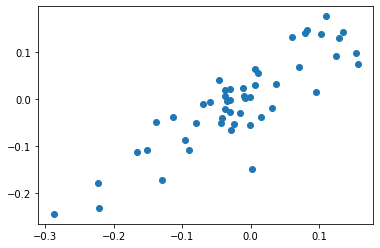

In [29]:
plt.scatter(x_mean,x_truth)

# AGEM signal denoise

In [2]:
import numpy as np

In [106]:
x = np.load('data/524_x.npy')

In [108]:
from AGEM.solver import solve_agem
import numpy as np

AGEM_samples = []
def run_test():
    x_dim = 50
    sigma_prior = hypers['sigma_prior'] # 对应新方法的 sigma_prior
    sigma_proposal = 0.01
    sigma_noise_hat_init = 0.01 # 初始项
    cov = np.identity(x_dim) * sigma_prior**2
    x_test = x
    x_true = x_test[:]

    noise_shape = x_true.shape[1:]
    n_dim = np.prod(noise_shape)


    for noise in [0.01,0.03,0.05]: #??   # 对应sigma_noise ，为真实的噪音取值！
        sigma_noise = [noise] * n_dim
        sigma_noise = np.array(sigma_noise[:n_dim]).reshape(noise_shape)
        print(sigma_noise)
        rmse_mean, rmse_std, noise_mean, noise_std,estimation = \
            solve_agem(x_true=x_true, sigma_noise=sigma_noise,
                       sigma_prior=sigma_prior, sigma_noise_hat_init=sigma_noise_hat_init,
                       sigma_proposal=sigma_proposal, type_proposal='mala',
                       candidate='mean', em_epochs=10, sample_epochs=1000)

        print('[AGEM] noise_gt: %.2f | rmse %.4f (%.4f), noise_est: %.4f (%.4f)' % (
            noise, rmse_mean, rmse_std, noise_mean, noise_std
        ))
        AGEM_samples.append(estimation)


if __name__ == '__main__':
    run_test()

[0.01]
epoch 0, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0100 (0.0003) | rmse: 0.0082 (0.0055)
epoch 1, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0101 (0.0005) | rmse: 0.0083 (0.0056)
epoch 2, time 0.0 sec | noise_gt: 0.0100, noise_est: 0.0101 (0.0006) | rmse: 0.0085 (0.0055)
epoch 3, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0101 (0.0008) | rmse: 0.0084 (0.0055)
epoch 4, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0101 (0.0008) | rmse: 0.0083 (0.0055)
epoch 5, time 0.0 sec | noise_gt: 0.0100, noise_est: 0.0102 (0.0009) | rmse: 0.0084 (0.0056)
epoch 6, time 0.0 sec | noise_gt: 0.0100, noise_est: 0.0103 (0.0011) | rmse: 0.0084 (0.0057)
epoch 7, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0104 (0.0012) | rmse: 0.0084 (0.0057)
epoch 8, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0104 (0.0014) | rmse: 0.0084 (0.0057)
epoch 9, time 0.1 sec | noise_gt: 0.0100, noise_est: 0.0105 (0.0017) | rmse: 0.0084 (0.0057)
[AGEM] noise_gt: 0.01 | rmse 0.0084 (0.0057), noise_est: 0.0105

In [67]:
AGEM_samples = np.array(AGEM_samples)
AGEM_samples.shape

(3, 20, 50)

In [68]:
AGEM = pd.DataFrame(np.vstack((AGEM_samples[0][2].flatten(),AGEM_samples[1][2].flatten(),AGEM_samples[2][2].flatten())))
AGEM.to_csv('AGEM_samples.csv')

In [41]:
AGEM_samples_mean = np.mean(AGEM_samples_mean,1)

In [43]:
AGEM_samples_mean = pd.DataFrame(AGEM_samples_mean)
AGEM_samples_mean.to_csv('AGEM_samples_mean.csv')

In [49]:
P = pd.DataFrame(P.reshape(4,50))
P.to_csv('our_mean.csv')

In [59]:
P

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.000509,-0.000121,0.000108,-0.000174,-0.000148,0.000198,-0.000040,-0.001298,-0.000202,0.000308,-0.000132,0.000108,-0.000036,-0.000447,-0.000074,0.000336,0.000027,0.000419,-0.000113,0.000373,-0.000118,-0.000571,0.000176,-0.000582,0.000001,0.000236,-0.000104,0.000138,-0.000495,0.000434,-0.000345,0.000029,-0.000459,0.000101,-0.000657,-0.000495,0.000031,-0.000347,0.000960,0.000201,-0.000167,0.000118,0.000204,0.000147,-0.000207,0.000242,-0.000026,-0.000296,0.000486,-0.000164
1,-0.001068,-0.000716,0.000503,0.000105,-0.000306,0.001081,-0.000398,-0.002848,-0.000354,0.000163,-0.000581,0.000487,0.000039,-0.000911,-0.000476,0.000942,-0.000160,0.000725,0.000118,0.000683,-0.000592,-0.001419,0.000035,-0.001005,0.000078,-0.000188,-0.000124,0.000158,-0.000458,0.001303,-0.000801,0.000096,-0.000706,-0.000645,-0.000805,-0.001356,0.000466,-0.000369,0.000920,0.000727,-0.000973,0.000100,0.000526,0.000423,0.000089,0.000538,0.000061,-0.000151,0.000056,0.000039
2,-0.001426,-0.000945,0.000539,0.000308,-0.000509,0.001520,-0.000218,-0.003771,-0.000591,-0.000198,-0.001444,0.000816,0.000138,-0.001261,-0.000597,0.001267,-0.000341,0.000913,0.000706,0.000778,-0.000653,-0.001775,-0.000062,-0.001305,-0.000176,-0.000579,-0.000192,0.000160,-0.000695,0.001938,-0.001122,0.000059,-0.000565,-0.001405,-0.000770,-0.001530,0.000622,-0.000308,0.000826,0.001423,-0.001568,0.000142,0.000788,0.000581,0.000130,0.000623,0.000328,0.000087,-0.000285,0.000395
3,-0.001966,-0.001163,0.000925,0.000331,-0.000364,0.002165,-0.000489,-0.004993,-0.000813,-0.000379,-0.002093,0.000724,0.000038,-0.001706,-0.001091,0.001909,-0.000720,0.000986,0.000332,0.000997,-0.001199,-0.002514,0.000128,-0.001795,0.000183,-0.000683,-0.000129,-0.000144,-0.000632,0.002754,-0.001543,0.000441,-0.000859,-0.001893,-0.000655,-0.002065,0.001277,-0.000277,0.000789,0.002324,-0.002218,0.000164,0.001142,0.000794,0.000719,0.000912,0.000322,0.000642,-0.000704,0.000706


In [60]:
pd.read_csv('.\our_mean.csv')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.000509,-0.000121,0.000108,-0.000174,-0.000148,0.000198,-0.000040,-0.001298,-0.000202,0.000308,-0.000132,0.000108,-0.000036,-0.000447,-0.000074,0.000336,0.000027,0.000419,-0.000113,0.000373,-0.000118,-0.000571,0.000176,-0.000582,0.000001,0.000236,-0.000104,0.000138,-0.000495,0.000434,-0.000345,0.000029,-0.000459,0.000101,-0.000657,-0.000495,0.000031,-0.000347,0.000960,0.000201,-0.000167,0.000118,0.000204,0.000147,-0.000207,0.000242,-0.000026,-0.000296,0.000486,-0.000164
1,1,-0.001068,-0.000716,0.000503,0.000105,-0.000306,0.001081,-0.000398,-0.002848,-0.000354,0.000163,-0.000581,0.000487,0.000039,-0.000911,-0.000476,0.000942,-0.000160,0.000725,0.000118,0.000683,-0.000592,-0.001419,0.000035,-0.001005,0.000078,-0.000188,-0.000124,0.000158,-0.000458,0.001303,-0.000801,0.000096,-0.000706,-0.000645,-0.000805,-0.001356,0.000466,-0.000369,0.000920,0.000727,-0.000973,0.000100,0.000526,0.000423,0.000089,0.000538,0.000061,-0.000151,0.000056,0.000039
2,2,-0.001426,-0.000945,0.000539,0.000308,-0.000509,0.001520,-0.000218,-0.003771,-0.000591,-0.000198,-0.001444,0.000816,0.000138,-0.001261,-0.000597,0.001267,-0.000341,0.000913,0.000706,0.000778,-0.000653,-0.001775,-0.000062,-0.001305,-0.000176,-0.000579,-0.000192,0.000160,-0.000695,0.001938,-0.001122,0.000059,-0.000565,-0.001405,-0.000770,-0.001530,0.000622,-0.000308,0.000826,0.001423,-0.001568,0.000142,0.000788,0.000581,0.000130,0.000623,0.000328,0.000087,-0.000285,0.000395
3,3,-0.001966,-0.001163,0.000925,0.000331,-0.000364,0.002165,-0.000489,-0.004993,-0.000813,-0.000379,-0.002093,0.000724,0.000038,-0.001706,-0.001091,0.001909,-0.000720,0.000986,0.000332,0.000997,-0.001199,-0.002514,0.000128,-0.001795,0.000183,-0.000683,-0.000129,-0.000144,-0.000632,0.002754,-0.001543,0.000441,-0.000859,-0.001893,-0.000655,-0.002065,0.001277,-0.000277,0.000789,0.002324,-0.002218,0.000164,0.001142,0.000794,0.000719,0.000912,0.000322,0.000642,-0.000704,0.000706


In [65]:
data1 = pd.read_csv('.\our_mean.csv')
data1 = data1.drop(data1.columns[[0]],axis = 1)
data1 = np.array(data1)
data1.shape


(4, 50)

In [67]:
data2 = pd.read_csv('AGEM_samples_mean.csv')
data2 = data2.drop(data2.columns[[0]],axis = 1)
data2 = np.array(data2)

In [19]:
df


,sigma0.01,sigma0.03,sigma0.05,kind,TRUE
0,-0.020061,-0.012072,-0.006576,AGEM,-0.009517
1,0.002311,0.020589,0.060092,AGEM,0.004325
2,0.007509,0.019467,0.016773,AGEM,0.008074
3,-0.005890,-0.011799,-0.005170,AGEM,-0.014607
4,-0.020143,-0.027948,-0.033163,AGEM,0.005725
5,0.003074,0.015191,0.006413,AGEM,-0.001085
6,-0.006570,0.028322,0.020603,AGEM,0.007790
7,-0.000660,-0.021008,-0.026160,AGEM,0.001461
8,0.022022,-0.014411,-0.033571,AGEM,0.005319
9,-0.005865,-0.004974,-0.013814,AGEM,-0.001234


In [27]:
df = pd.read_csv('df.csv')
u1=np.array(df[['sigma0.01']])[:50]
u3=np.array(df[['sigma0.03']])[:50]
u5=np.array(df[['sigma0.05']])[:50]
u = np.array(df[['TRUE']])[:50]

In [32]:
np.sum((u-u.mean())**2)

0.0037586999874183124

In [35]:
np.sum((u-u1)**2)

0.011760322822949493

In [28]:
def r2(u1,u):
    u_mean = u.mean()
    sst = np.sum((u-u_mean)**2)
    ssr = np.sum((u-u1)**2)
    r2=1-ssr/sst
    return r2

In [30]:
# agem
r2(u1,u),r2(u3,u),r2(u5,u)

(-2.1288272174729084, -5.105493991195226, -10.348334586740886)

In [36]:
u1=np.array(df[['sigma0.01']])[50:]
u3=np.array(df[['sigma0.03']])[50:]
u5=np.array(df[['sigma0.05']])[50:]
u = np.array(df[['TRUE']])[50:]

In [38]:
r2(u1,u),r2(u3,u),r2(u5,u)

(0.2007317984042497, 0.04437674908766187, -0.05702215758343465)

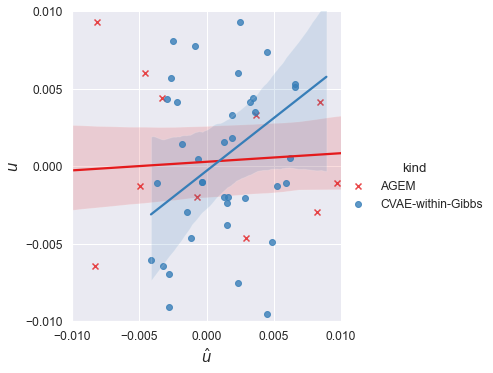

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1.1)
g = sns.lmplot(x="sigma0.03", y="TRUE", hue="kind", data=df, palette="Set1",markers=["x", "o"])
g = (g.set(xlim=(-0.01, 0.01), ylim=(-0.01, 0.01),xticks=[-0.01, -0.005, 0,0.005,0.01], yticks=[-0.01, -0.005, 0,0.005,0.01]))
plt.xlabel("$\hat{u}$",fontsize = 15)
plt.ylabel("$u$",fontsize = 15)
plt.savefig('sigma0.03.pdf')

操作方案：首先找到我们的方法中每一个固定sigma中，20个真实数据集中与真实值的RMSE最小的数据，作为使用我们的方法所得到的反演结果。然后取得，agem对应的数据【每一次的第三个数据集】结果作为使用该方法得到的反演结果。然后再进行画图，希望得到的效果是，所有的点都尽量在一条曲线上。

问题：为啥我们的方法得到的x反演值都是在0附近，没有扩展到其他的区域，是否说明方法上的问题？